# Toonify yourself!

Please ensure that you're using a GPU runtime

First some setup:

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
!git clone https://github.com/justinpinkney/stylegan2
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.32 MiB | 13.72 MiB/s, done.
Resolving deltas: 100% (141/141), done.
/content/stylegan2
CPU says hello.
GPU says hello.


In [4]:
!mkdir raw
!mkdir aligned
!mkdir generated

## Upload your own photos

Upload your photos to `raw/`. These don't need to be aligned as we'll use a face detector to grab all the faces and transform them into the correct format. One note of caution is that you'll need a pretty high-resolution picture of a face to get a sharp result (the final face crop is resized to 1024x1024 pixels)

We'll grab a example image from the internet to work with.

The basic process is:
- Extract faces and align the images
- Project the images (i.e. find the latent code)
- Toonify the images (i.e. use the latent code with the toon model)

Results will be placed in the stylegan2/generated folder

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
%cd '/content/stylegan2/raw'
! unzip '/content/gdrive/MyDrive/301/project/GANproject/cartoon_data.zip'

/content/stylegan2/raw
Archive:  /content/gdrive/MyDrive/301/project/GANproject/cartoon_data.zip
   creating: cartoon_data/
  inflating: __MACOSX/._cartoon_data  
  inflating: cartoon_data/.DS_Store  
  inflating: __MACOSX/cartoon_data/._.DS_Store  
   creating: cartoon_data/trainB/
  inflating: __MACOSX/cartoon_data/._trainB  
   creating: cartoon_data/testB/
  inflating: __MACOSX/cartoon_data/._testB  
  inflating: cartoon_data/trainB/176.png  
  inflating: __MACOSX/cartoon_data/trainB/._176.png  
  inflating: cartoon_data/trainB/162.png  
  inflating: __MACOSX/cartoon_data/trainB/._162.png  
  inflating: cartoon_data/trainB/189.png  
  inflating: __MACOSX/cartoon_data/trainB/._189.png  
  inflating: cartoon_data/trainB/002.png  
  inflating: __MACOSX/cartoon_data/trainB/._002.png  
  inflating: cartoon_data/trainB/016.png  
  inflating: __MACOSX/cartoon_data/trainB/._016.png  
  inflating: cartoon_data/trainB/017.png  
  inflating: __MACOSX/cartoon_data/trainB/._017.png  
  inflatin

In [8]:
!wget https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg raw/example.png

--2022-05-15 14:41:28--  https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332712 (325K) [image/jpeg]
Saving to: ‘Shinzō_Abe_Official.jpg’

Shinzō_Abe_Official 100%[===================>] 324.91K  --.-KB/s    in 0.02s   

2022-05-15 14:41:28 (17.1 MB/s) - ‘Shinzō_Abe_Official.jpg’ saved [332712/332712]

--2022-05-15 14:41:28--  http://raw/example.png
Resolving raw (raw)... failed: Name or service not known.
wget: unable to resolve host address ‘raw’
FINISHED --2022-05-15 14:41:28--
Total wall clock time: 0.2s
Downloaded: 1 files, 325K in 0.02s (17.1 MB/s)


In [9]:
import sys
sys.path.append('/content/stylegan2')

import pretrained_networks


In [10]:
 !gdown https://drive.google.com/uc?id=1-p0zIkWPXjcwYZ6tPw_kNjn4e1gD2lnz
 !wget https://hanlab.mit.edu/projects/data-efficient-gans/models/stylegan2-ffhq.pkl

Downloading...
From: https://drive.google.com/uc?id=1-p0zIkWPXjcwYZ6tPw_kNjn4e1gD2lnz
To: /content/stylegan2/raw/epic-slim-256-000040.pkl
100% 296M/296M [00:02<00:00, 107MB/s]
--2022-05-15 14:41:36--  https://hanlab.mit.edu/projects/data-efficient-gans/models/stylegan2-ffhq.pkl
Resolving hanlab.mit.edu (hanlab.mit.edu)... 18.25.8.36
Connecting to hanlab.mit.edu (hanlab.mit.edu)|18.25.8.36|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tinyml.mit.edu/projects/data-efficient-gans/models/stylegan2-ffhq.pkl [following]
--2022-05-15 14:41:36--  https://tinyml.mit.edu/projects/data-efficient-gans/models/stylegan2-ffhq.pkl
Resolving tinyml.mit.edu (tinyml.mit.edu)... 18.25.8.134
Connecting to tinyml.mit.edu (tinyml.mit.edu)|18.25.8.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 295721852 (282M)
Saving to: ‘stylegan2-ffhq.pkl’

stylegan2-ffhq.pkl  100%[===================>] 282.02M  34.8MB/s    in 8.7s    

2022

In [49]:
# use my copy of the blended model to save Doron's download bandwidth
# get the original here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
# blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU" 
 
blended_url = '/content/gdrive/MyDrive/301/project/GANproject/ffhq-cartoon-blended-64.pkl'
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

In [50]:
!python /content/stylegan2/align_images.py /content/stylegan2/raw/ming /content/stylegan2/aligned

In [51]:
!python /content/stylegan2/project_images.py --num-steps 500 /content/stylegan2/aligned /content/stylegan2/generated

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "ming_01.png"...


In [65]:
pip install dlib

In [75]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("/content/stylegan2/generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  print("round")
  print("load: ", np.load(latent_file))
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))


round
load:  [[ 1.2061454   1.4175515   2.0984433  ...  1.0357797  -0.80652755
   2.0217874 ]
 [-3.1850457   0.96498054  0.4872129  ...  0.25859374  1.3703357
   0.8502065 ]
 [ 0.4797752  -0.10251568  1.2749355  ... -0.828214    0.2969433
   1.1793451 ]
 ...
 [ 0.47767127 -0.27534324 -0.17389062 ... -2.256197    1.3544899
   0.15679942]
 [ 0.6091208   0.80787104  0.6763416  ... -0.61529416  0.11550866
   0.7617939 ]
 [ 0.11889278 -0.18991032  0.2173244  ... -0.3042058  -0.1627443
   0.35817719]]
round
load:  [[ 0.9897512  -1.0301468   1.90801    ... -0.7991921   0.6565164
   1.0413971 ]
 [-1.1552414  -1.7415605   2.7490249  ...  0.8252648  -0.81473744
   1.3980258 ]
 [ 2.4446485  -0.6292803   1.9476265  ...  0.65729666  1.7504603
   2.635321  ]
 ...
 [ 0.44900426  0.4873654  -0.22332637 ... -2.5739515  -0.1939294
   0.42750692]
 [ 0.9428928   0.883904    0.5079613  ... -0.03197291  0.8074211
   0.7096375 ]
 [ 0.60871387  0.27282888  0.01801272 ... -0.23358834 -0.37694234
   0.57792705]

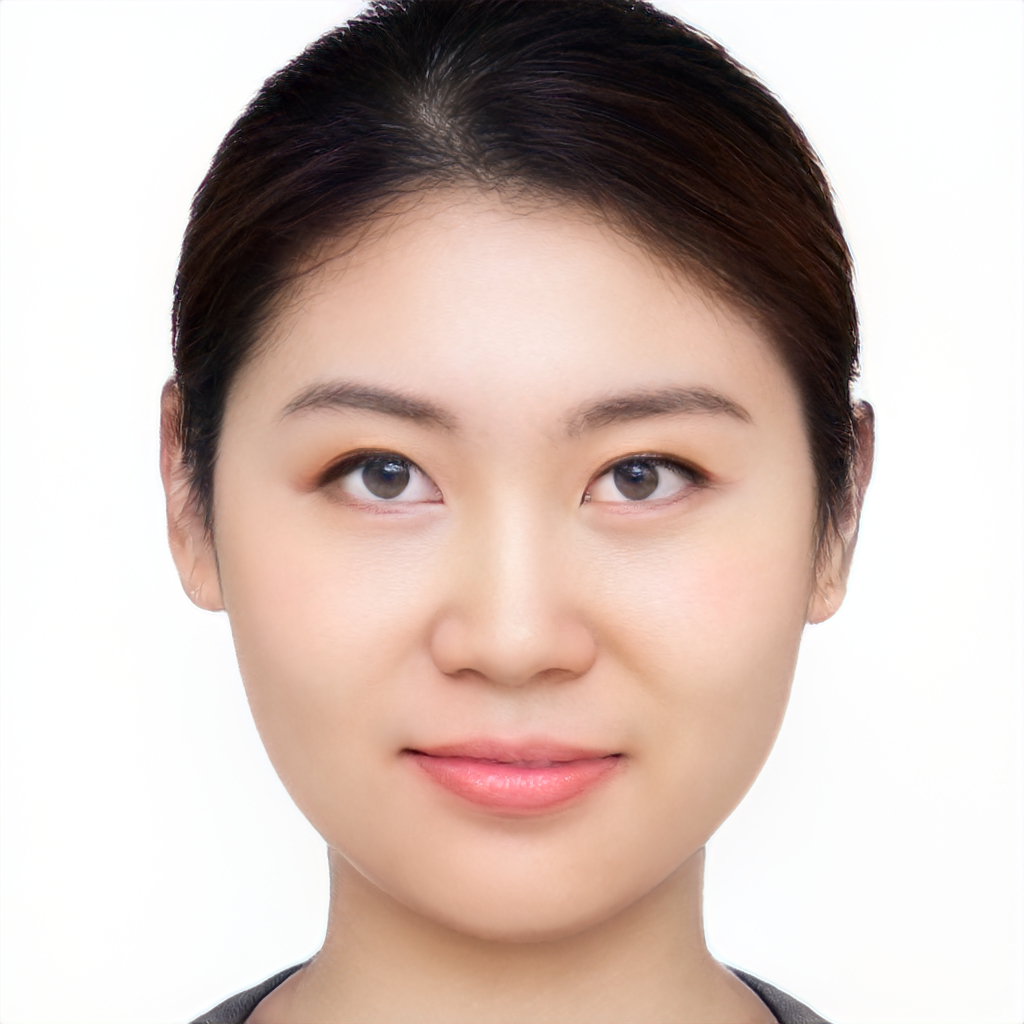

'tooned = Image(filename="/content/stylegan2/generated/ming_01.npy", width=256)\ndisplay(tooned)'

In [76]:
from IPython.display import Image 
embedded = Image(filename="/content/stylegan2/generated/ming_01.png", width=256)
display(embedded)
"""tooned = Image(filename="/content/stylegan2/generated/ming_01.npy", width=256)
display(tooned)"""

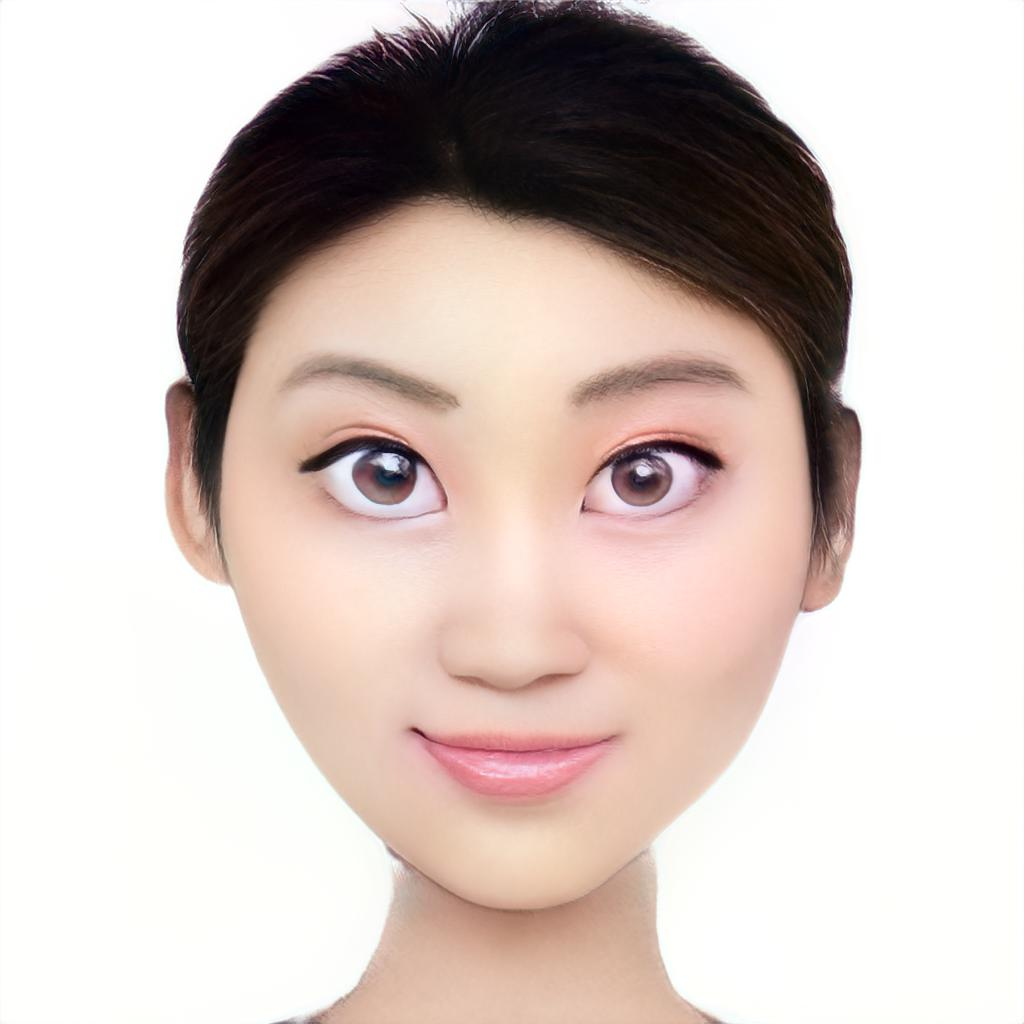

In [78]:
tooned = Image(filename="/content/stylegan2/generated/ming_01-toon.jpg", width=256)
display(tooned)

In [1]:
%cd /content

/content


In [2]:
! git clone https://github.com/NVlabs/stylegan2-ada.git


Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 74, done.
remote: Total 74 (delta 0), reused 0 (delta 0), pack-reused 74
Unpacking objects: 100% (74/74), done.


In [3]:
%cd /content/stylegan2-ada

/content/stylegan2-ada


In [4]:
# Dowload dataset
!wget "https://www.dropbox.com/s/0ybsudabqscstf7/biked_dataset.tar.gz" -q -O biked_dataset.tar.gz
# extract dataset
!tar -zxvf biked_dataset.tar.gz
# Delete the tar.gz file
!rm biked_dataset.tar.gz

^C
biked/
biked/bike (3122).jpg
biked/bike (4716).jpg
biked/bike (2791).jpg
biked/bike (2809).jpg
biked/bike (1135).jpg
biked/bike (591).jpg
biked/bike (1205).jpg
biked/bike (1557).jpg
biked/bike (3130).jpg
biked/bike (1768).jpg
biked/bike (1625).jpg
biked/bike (4072).jpg
biked/bike (2563).jpg
biked/bike (1407).jpg
biked/bike (961).jpg
biked/bike (3213).jpg
biked/bike (836).jpg
biked/bike (674).jpg
biked/bike (2262).jpg
biked/bike (3010).jpg
biked/bike (2345).jpg
biked/bike (3437).jpg
biked/bike (2675).jpg
biked/bike (1837).jpg
biked/bike (31).jpg
biked/bike (3117).jpg
biked/bike (2499).jpg
biked/bike (3529).jpg
biked/bike (2250).jpg
biked/bike (572).jpg
biked/bike (3233).jpg
biked/bike (2588).jpg
biked/bike (2300).jpg
biked/bike (2214).jpg

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [9]:
%cd '/content/stylegan2-ada'
! unzip '/content/gdrive/MyDrive/301/project/GANproject/cartoon_data.zip'

/content/stylegan2-ada
Archive:  /content/gdrive/MyDrive/301/project/GANproject/cartoon_data.zip
   creating: cartoon_data/
  inflating: __MACOSX/._cartoon_data  
  inflating: cartoon_data/.DS_Store  
  inflating: __MACOSX/cartoon_data/._.DS_Store  
   creating: cartoon_data/trainB/
  inflating: __MACOSX/cartoon_data/._trainB  
   creating: cartoon_data/testB/
  inflating: __MACOSX/cartoon_data/._testB  
  inflating: cartoon_data/trainB/176.png  
  inflating: __MACOSX/cartoon_data/trainB/._176.png  
  inflating: cartoon_data/trainB/162.png  
  inflating: __MACOSX/cartoon_data/trainB/._162.png  
  inflating: cartoon_data/trainB/189.png  
  inflating: __MACOSX/cartoon_data/trainB/._189.png  
  inflating: cartoon_data/trainB/002.png  
  inflating: __MACOSX/cartoon_data/trainB/._002.png  
  inflating: cartoon_data/trainB/016.png  
  inflating: __MACOSX/cartoon_data/trainB/._016.png  
  inflating: cartoon_data/trainB/017.png  
  inflating: __MACOSX/cartoon_data/trainB/._017.png  
  inflatin

In [5]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.3 MB 1.3 MB/s 
     |████████████████████████████████| 488 kB 70.0 MB/s 
     |████████████████████████████████| 50 kB 9.2 MB/s 
     |████████████████████████████████| 3.1 MB 55.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but yo

In [10]:
!python dataset_tool.py create_from_images ./datasets/face /content/stylegan2-ada/cartoon_data/trainB

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [11]:
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [12]:
tf.compat.v1.disable_eager_execution()

In [13]:
!python train.py --outdir ./results --snap=10 --data=/content/stylegan2-ada/datasets/face --augpipe=bgcfnc --res=512 --resume=/content/gdrive/MyDrive/301/project/GANproject/ffhq.pkl

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 